# A Movie Recommendation Service - Ripe-Pumpkin 
### Source: https://www.codementor.io/spark/tutorial/building-a-recommender-with-apache-spark-python-example-app-part1

#### Create a SparkContext configured for local mode

In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')

#### File download 
Full: 27,753,444 ratings applied to 58,098 movies by 283,228 users. Last updated 2019-12-03.

In [2]:
complete_dataset_url = 'http://files.grouplens.org/datasets/movielens/ml-latest.zip'
# small_dataset_url = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

#### Download location(s)

In [3]:
import os
datasets_path = os.path.join('/home/jovyan', 'work')

complete_dataset_path = os.path.join(datasets_path, 'ml-latest.zip')
# small_dataset_path = os.path.join(datasets_path, 'ml-latest-small.zip')

#### Getting file(s)

In [4]:
import urllib.request
complete_f = urllib.request.urlretrieve (complete_dataset_url, complete_dataset_path)
# small_f = urllib.request.urlretrieve (small_dataset_url, small_dataset_path)

#### Extracting file(s)

In [5]:
import zipfile
 
with zipfile.ZipFile(complete_dataset_path, "r") as z:
    z.extractall(datasets_path)
    
# with zipfile.ZipFile(small_dataset_path, "r") as z:
#     z.extractall(datasets_path)

## Loading and parsing datasets
Now we are ready to read in each of the files and create an RDD consisting of parsed lines. 

Each line in the ratings dataset (ratings.csv) is formatted as: 
+ userId,movieId,rating,timestamp 

Each line in the movies (movies.csv) dataset is formatted as:
+ movieId,title,genres 

### We will now load the raw data, filter out the header, and parse the data into a new RDD

#### ratings.csv

In [6]:
complete_ratings_file = os.path.join(datasets_path, 'ml-latest', 'ratings.csv')
complete_ratings_raw_data = sc.textFile(complete_ratings_file)
complete_ratings_raw_data_header = complete_ratings_raw_data.take(1)[0]
# Parse
complete_ratings_data = complete_ratings_raw_data.filter(lambda line: line!=complete_ratings_raw_data_header)\
    .map(lambda line: line.split(",")).map(lambda tokens: (int(tokens[0]),int(tokens[1]),float(tokens[2]))).cache()

print ('There are {} recommendations in the complete dataset'.format(complete_ratings_data.count()))
complete_ratings_data = complete_ratings_data.sample(False, 0.10,42)
complete_ratings_data.take(3)

There are 27753444 recommendations in the complete dataset


[(1, 307, 3.5), (1, 1257, 4.5), (1, 2986, 2.5)]

#### movies.csv

In [7]:
# Load the small dataset file
complete_movies_file = os.path.join(datasets_path, 'ml-latest', 'movies.csv')
complete_movies_raw_data = sc.textFile(complete_movies_file)
complete_movies_raw_data_header = complete_movies_raw_data.take(1)[0]

# Parse
complete_movies_data = complete_movies_raw_data.filter(lambda line: line!=complete_movies_raw_data_header)\
    .map(lambda line: line.split(",")).map(lambda tokens: (int(tokens[0]),tokens[1],tokens[2])).cache()

complete_movies_titles = complete_movies_data.map(lambda x: (int(x[0]),x[1]))
print ('There are {} movies in the complete dataset'.format(complete_movies_titles.count()))
complete_movies_data = complete_movies_data.sample(False, 0.10,42)
complete_movies_data.take(3)

There are 58098 movies in the complete dataset


[(1, 'Toy Story (1995)', 'Adventure|Animation|Children|Comedy|Fantasy'),
 (4, 'Waiting to Exhale (1995)', 'Comedy|Drama|Romance'),
 (11, '"American President', ' The (1995)"')]

# Import pandas and read as DF
###### This was just to get a look at quick descriptive variables

In [8]:
import pandas as pd
# Read it in as a data frame
movies_df = pd.read_csv(complete_movies_file)
ratings_df = pd.read_csv(complete_ratings_file)


In [9]:
# Show a sample of the movie data
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
# Show sample of the ratings data
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [11]:
# Length of each df
print("length of the ratings df is {}".format(len(ratings_df)))
print("length of the movies df is {}".format(len(movies_df)))

unique_rating = ratings_df.groupby('rating').agg({'userId': 'nunique'})
print("Number or unique users that responded with ratings {}".format(unique_rating))

average_rating = ratings_df.agg({'rating':'mean'})
print("Average rating collected from data set is {}".format(average_rating))

num_unique_users = ratings_df.agg({'userId':'nunique'})
print("There are {} unique users that have contibuted to this rating pool".format(num_unique_users))

length of the ratings df is 27753444
length of the movies df is 58098
Number or unique users that responded with ratings         userId
rating        
0.5      64259
1.0     135726
1.5      73710
2.0     189352
2.5     113452
3.0     248815
3.5     143890
4.0     263790
4.5     139104
5.0     241003
Average rating collected from data set is rating    3.530445
dtype: float64
There are userId    283228
dtype: int64 unique users that have contibuted to this rating pool


In [12]:
# Convert to time stamp 
time_df = ratings_df
time_df['time_stamp'] = pd.to_datetime(ratings_df['timestamp'])

# Pick out the max and min date range
range_res = time_df.agg({'time_stamp':['max', 'min']})
print("Time for ratings ranged from {}".format(range_res))

Time for ratings ranged from                        time_stamp
max 1970-01-01 00:00:01.537945149
min 1970-01-01 00:00:00.789652004


In [13]:
# Discribe movies df
movies_df.describe()

,movieId
count,58098.000000
mean,111919.516197
std,59862.660956
min,1.000000
25%,72437.750000
50%,126549.000000
75%,161449.500000
max,193886.000000


In [14]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,2.775344e+07,2.775344e+07,2.775344e+07,2.775344e+07
mean,1.419420e+05,1.848800e+04,3.530445e+00,1.193122e+09
std,8.170740e+04,3.510263e+04,1.066353e+00,2.160482e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,7.117600e+04,1.097000e+03,3.000000e+00,9.986053e+08
50%,1.420220e+05,2.716000e+03,3.500000e+00,1.174256e+09
75%,2.124590e+05,7.150000e+03,4.000000e+00,1.422744e+09
max,2.832280e+05,1.938860e+05,5.000000e+00,1.537945e+09


(array([ 442388.,  886233.,  441354., 1850627., 1373419., 5515668.,
        3404360., 7394710., 2373550., 4071135.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <BarContainer object of 10 artists>)

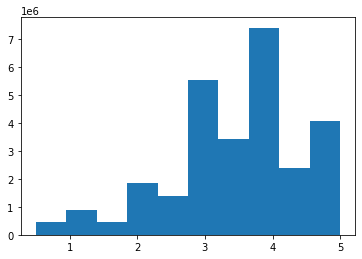

In [41]:
import matplotlib.pyplot as plt

plt.hist(ratings_df['rating'])

#### Back to RDD work

## Collaborative Filtering
In Collaborative filtering we make predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption is that if a user A has the same opinion as a user B on an issue, A is more likely to have B's opinion on a different issue x than to have the opinion on x of a user chosen randomly. 

At first, people rate different items (like videos, images, games). Then, the system makes predictions about a user's rating for an item not rated yet. The new predictions are built upon the existing ratings of other users with similar ratings with the active user. In the image, the system predicts that the user will not like the video.

Spark MLlib library for Machine Learning provides a Collaborative Filtering implementation by using Alternating Least Squares. The implementation in MLlib has the following parameters:

+ numBlocks is the number of blocks used to parallelize computation (set to -1 to auto-configure).
+ rank is the number of latent factors in the model.
+ iterations is the number of iterations to run.
+ lambda specifies the regularization parameter in ALS.
+ implicitPrefs specifies whether to use the explicit feedback ALS variant or one adapted for implicit feedback data.
+ alpha is a parameter applicable to the implicit feedback variant of ALS that governs the baseline confidence in preference observations.

#### Selecting ALS parameters using 10% of the full dataset
In order to determine the best ALS parameters, we need first to split it into train, validation, and test datasets.

In [15]:
# source uses see=0L, which is the previous version of python (2.x)
# 0L should be written as 0 from now on
training_RDD, validation_RDD, test_RDD = complete_ratings_data.randomSplit([6, 2, 2], seed=0)
validation_for_predict_RDD = validation_RDD.map(lambda x: (x[0], x[1]))
test_for_predict_RDD = test_RDD.map(lambda x: (x[0], x[1]))

#### Training phase

In [16]:
from pyspark.mllib.recommendation import ALS
import math

seed = 5
iterations = 10
regularization_parameter = 0.1
ranks = [4, 8, 12]
errors = [0, 0, 0]
err = 0
tolerance = 0.02

min_error = float('inf')
best_rank = -1
best_iteration = -1

for rank in ranks:
    model = ALS.train(training_RDD, rank, seed=seed, iterations=iterations,
                      lambda_=regularization_parameter)
    predictions = model.predictAll(validation_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = validation_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
    error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    errors[err] = error
    err += 1
    print ('For rank {} the RMSE is {}'.format(rank, error))
    if error < min_error:
        min_error = error
        best_rank = rank

print ('The best model was trained with rank {}'.format(best_rank))

For rank 4 the RMSE is 0.9789952472834301
For rank 8 the RMSE is 0.9936466156402521
For rank 12 the RMSE is 0.9980974326180787
The best model was trained with rank 4


In [17]:
# Looking at our new predictions alone
predictions.take(3)

[((269599, 593), 3.7484784276673055),
 ((279323, 1101), 3.7631367425494306),
 ((279323, 2710), 2.5732641571948576)]

In [18]:
# Looking at our predictions relitive to the observed value
rates_and_preds.take(3)

[((4, 170), (3.0, 3.6398973205389753)),
 ((23, 1231), (3.0, 4.161464165987251)),
 ((31, 2791), (4.0, 3.798922728627975))]

#### Finally we test the selected model.

In [19]:
model = ALS.train(training_RDD, best_rank, seed=seed, iterations=iterations,
                      lambda_=regularization_parameter)
predictions = model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
rates_and_preds = test_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    
print ('For testing data the RMSE is %s' % (error))

For testing data the RMSE is 0.9821325201162072


## Using the complete dataset to build the final model
Due to the limitations of virtual machine, we keep using the partial dataset instead of complete dataset

In [20]:
complete_movies_file = os.path.join(datasets_path, 'ml-latest', 'movies.csv')
complete_movies_raw_data = sc.textFile(complete_movies_file)
complete_movies_raw_data_header = complete_movies_raw_data.take(1)[0]

# Parse
complete_movies_data = complete_movies_raw_data.filter(lambda line: line!=complete_movies_raw_data_header)\
    .map(lambda line: line.split(",")).map(lambda tokens: (int(tokens[0]),tokens[1],tokens[2])).cache()

complete_movies_titles = complete_movies_data.map(lambda x: (int(x[0]),x[1]))
    
print ("There are %s movies in the complete dataset" % (complete_movies_titles.count()))

There are 58098 movies in the complete dataset


In [21]:
#### Now we are ready to trai the recomender model
training_RDD, test_RDD = complete_ratings_data.randomSplit([7, 3], seed=0)

complete_model = ALS.train(training_RDD, best_rank, seed=seed, 
                           iterations=iterations, lambda_=regularization_parameter)

In [22]:
# Now we test on our testing set
test_for_predict_RDD = test_RDD.map(lambda x: (x[0], x[1]))

predictions = complete_model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
rates_and_preds = test_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    
print ('For testing data the RMSE is %s' % (error))

For testing data the RMSE is 0.958582993083312


## How to make recommendations
Although we aim at building an online movie recommender, now that we know how to have our recommender model ready, we can give it a try providing some movie recommendations. This will help us coding the recommending engine later on when building the web service, and will explain how to use the model in any other circumstances.

When using collaborative filtering, getting recommendations is not as simple as predicting for the new entries using a previously generated model. Instead, we need to train again the model but including the new user preferences in order to compare them with other users in the dataset. That is, the recommender needs to be trained every time we have new user ratings (although a single model can be used by multiple users of course!). This makes the process expensive, and it is one of the reasons why scalability is a problem (and Spark a solution!). Once we have our model trained, we can reuse it to obtain top recomendations for a given user or an individual rating for a particular movie. These are less costly operations than training the model itself.

##### let's first load the movies complete file for later use

In [23]:
complete_movies_file = os.path.join(datasets_path, 'ml-latest', 'movies.csv')
complete_movies_raw_data = sc.textFile(complete_movies_file)
complete_movies_raw_data_header = complete_movies_raw_data.take(1)[0]

# Parse
complete_movies_data = complete_movies_raw_data.filter(lambda line: line!=complete_movies_raw_data_header)\
    .map(lambda line: line.split(",")).map(lambda tokens: (int(tokens[0]),tokens[1],tokens[2])).cache()

complete_movies_titles = complete_movies_data.map(lambda x: (int(x[0]),x[1]))
    
print ("There are %s movies in the complete dataset" % (complete_movies_titles.count()))

There are 58098 movies in the complete dataset


Another thing we want to do, is give recommendations of movies with a certain minimum number of ratings. For that, we need to count the number of ratings per movie.

In [24]:
def get_counts_and_averages(ID_and_ratings_tuple):
    nratings = len(ID_and_ratings_tuple[1])
    return ID_and_ratings_tuple[0], (nratings, float(sum(x for x in ID_and_ratings_tuple[1]))/nratings)

movie_ID_with_ratings_RDD = (complete_ratings_data.map(lambda x: (x[1], x[2])).groupByKey())
movie_ID_with_avg_ratings_RDD = movie_ID_with_ratings_RDD.map(get_counts_and_averages)
movie_rating_counts_RDD = movie_ID_with_avg_ratings_RDD.map(lambda x: (x[0], x[1][0]))

### Adding new user ratings
Now we need to rate some movies for the new user. We will put them in a new RDD and we will use the user ID 0, that is not assigned in the MovieLens dataset. Check the dataset movies file for ID to Tittle assignment (so you know what movies are you actually rating).

In [25]:
new_user_ID = 0

# The format of each line is (userID, movieID, rating)

# ###################################################
# Keep the userID, but Replace movieID, rating, title
# ###################################################

# Find 10 movies you have watched in the past
# Put your OWN ratings

new_user_ratings = [
     (0,260,4), # Star Wars (1977)
     (0,1,3), # Toy Story (1995)
     (0,16,3), # Casino (1995)
     (0,25,4), # Leaving Las Vegas (1995)
     (0,32,4), # Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
     (0,335,1), # Flintstones, The (1994)
     (0,379,1), # Timecop (1994)
     (0,296,3), # Pulp Fiction (1994)
     (0,858,5), # Godfather, The (1972)
     (0,50,4) # Usual Suspects, The (1995)
    ]
new_user_ratings_RDD = sc.parallelize(new_user_ratings)
print ('New user ratings: {}'.format(new_user_ratings_RDD.take(10)))

New user ratings: [(0, 260, 4), (0, 1, 3), (0, 16, 3), (0, 25, 4), (0, 32, 4), (0, 335, 1), (0, 379, 1), (0, 296, 3), (0, 858, 5), (0, 50, 4)]


Now we add them to the data we will use to train our recommender model. We use Spark's union() transformation for this.

In [26]:
# sample_70 = complete_ratings_data.sample(False, 0.7, 42)
# complete_data_with_new_ratings_RDD = sample_70.union(new_user_ratings_RDD)

complete_data_with_new_ratings_RDD = complete_ratings_data.union(new_user_ratings_RDD)

And finally we train the ALS model using all the parameters we selected before (when using the small dataset).

In [27]:
from time import time

t0 = time()
new_ratings_model = ALS.train(complete_data_with_new_ratings_RDD, best_rank, seed=seed,
                              iterations=iterations, lambda_=regularization_parameter)
tt = time() - t0

print ('New model trained in {} seconds'.format(round(tt,3)))

New model trained in 47.144 seconds


## Getting top recommendations
Let's now get some recommendations! For that we will get an RDD with all the movies the new user hasn't rated yet. We will them together with the model to predict ratings.

In [28]:
new_user_ratings_ids = map(lambda x: x[1], new_user_ratings) # get just movie IDs
# keep just those not on the ID list (thanks Lei Li for spotting the error!)
new_user_unrated_movies_RDD = (complete_movies_data.filter(lambda x: x[0] not in new_user_ratings_ids).map(lambda x: (new_user_ID, x[0])))

# Use the input RDD, new_user_unrated_movies_RDD, with new_ratings_model.predictAll() to predict new ratings for the movies
new_user_recommendations_RDD = new_ratings_model.predictAll(new_user_unrated_movies_RDD)

We have our recommendations ready. Now we can print out the 25 movies with the highest predicted ratings. And join them with the movies RDD to get the titles, and ratings count in order to get movies with a minimum number of counts. First we will do the join and see what does the result looks like.

In [29]:
# Transform new_user_recommendations_RDD into pairs of the form (Movie ID, Predicted Rating)
new_user_recommendations_rating_RDD = new_user_recommendations_RDD.map(lambda x: (x.product, x.rating))
new_user_recommendations_rating_title_and_count_RDD = \
    new_user_recommendations_rating_RDD.join(complete_movies_titles).join(movie_rating_counts_RDD)
new_user_recommendations_rating_title_and_count_RDD.take(3)

[(6216,
  ((3.076647358067289, 'Nowhere in Africa (Nirgendwo in Afrika) (2001)'), 73)),
 (167832, ((3.140788473425439, 'The Invisible Guest (2016)'), 25)),
 (80808, ((2.4415489706842823, '"Night Strangler'), 2))]

So we need to flat this down a bit in order to have (Title, Rating, Ratings Count).

In [30]:
new_user_recommendations_rating_title_and_count_RDD = \
    new_user_recommendations_rating_title_and_count_RDD.map(lambda r: (r[1][0][1], r[1][0][0], r[1][1]))

Finally, get the highest rated recommendations for the new user, filtering out movies with less than 25 ratings.

In [31]:
top_movies = new_user_recommendations_rating_title_and_count_RDD.filter(lambda r: r[2]>=25).takeOrdered(15, key=lambda x: -x[1])

print ('TOP recommended movies (with more than 25 reviews):\n{}'.format('\n'.join(map(str, top_movies))))

TOP recommended movies (with more than 25 reviews):
('Eddie Izzard: Dress to Kill (1999)', 4.580889503989454, 48)
('"Honest Liar', 4.527483288603637, 26)
('Louis C.K.: Live at the Beacon Theater (2011)', 4.43691630007984, 183)
('Heart of a Dog (Sobachye serdtse) (1988)', 4.394862160617029, 76)
('American Pimp (1999)', 4.288118540832867, 33)
('"Room', 4.244631122510164, 62)
('As it is in Heaven (Så som i himmelen) (2004)', 4.242746637250008, 30)
('Louis C.K.: Hilarious (2010)', 4.240945929491364, 172)
('Over the Garden Wall (2013)', 4.200196279456925, 31)
("Vampire's Kiss (1989)", 4.165583278820783, 26)
('Roger & Me (1989)', 4.142298831653164, 830)
('"Night Porter', 4.1387160676152455, 33)
('Tekkonkinkreet (Tekkon kinkurîto) (2006)', 4.133562668669271, 43)
('High Art (1998)', 4.109954373531242, 108)
('Heima (2007)', 4.1022903421916315, 29)


## Getting individual ratings
Another useful usecase is getting the predicted rating for a particular movie for a given user. The process is similar to the previous retreival of top recommendations but, instead of using predcitAll with every single movie the user hasn't rated yet, we will just pass the method a single entry with the movie we want to predict the rating for.

In [32]:
my_movie = sc.parallelize([(0, 500)]) # Quiz Show (1994)
individual_movie_rating_RDD = new_ratings_model.predictAll(new_user_unrated_movies_RDD)
individual_movie_rating_RDD.take(1)

[Rating(user=0, product=116688, rating=0.3524519520761742)]

# Scenario #1 
### 10 movies I have watched w/ more than 25 ratings

In [33]:
# The format of each line is (userID, movieID, rating)

# S1 - 10 movies I have watched.

new_user_ratings = [
     (0,2657,2), # Rocky Horror Picture Show
     (0,2944,2), # Dirty Dozen, The (1967)
     (0,2992,1), # Rawhead Rex (1986)
     (0,103228,2), # Pacific Rim (2013)
     (0,104076,3), # Smurfs 2, The (2013)
     (0,356,5), # Forrest Gump (1994)
     (0,2959,5), # Fight Club (1999)
     (0,54256,5), # Hot Rod (2007)
     (0,260,4), # Star Wars (1977)
     (0,1,3), # Toy Story (1995)
    ]

new_user_ratings_RDD = sc.parallelize(new_user_ratings)
print ('New user ratings: {}'.format(new_user_ratings_RDD.take(10)))

complete_data_with_new_ratings_RDD = complete_ratings_data.union(new_user_ratings_RDD)

from time import time

t0 = time()
new_ratings_model = ALS.train(complete_data_with_new_ratings_RDD, best_rank, seed=seed,
                              iterations=iterations, lambda_=regularization_parameter)
tt = time() - t0

print ('New model trained in {} seconds'.format(round(tt,3)))

new_user_ratings_ids = map(lambda x: x[1], new_user_ratings) # get just movie IDs
# keep just those not on the ID list (thanks Lei Li for spotting the error!)
new_user_unrated_movies_RDD = (complete_movies_data.filter(lambda x: x[0] not in new_user_ratings_ids).map(lambda x: (new_user_ID, x[0])))

# Use the input RDD, new_user_unrated_movies_RDD, with new_ratings_model.predictAll() to predict new ratings for the movies
new_user_recommendations_RDD = new_ratings_model.predictAll(new_user_unrated_movies_RDD)

# Transform new_user_recommendations_RDD into pairs of the form (Movie ID, Predicted Rating)
new_user_recommendations_rating_RDD = new_user_recommendations_RDD.map(lambda x: (x.product, x.rating))
new_user_recommendations_rating_title_and_count_RDD = \
    new_user_recommendations_rating_RDD.join(complete_movies_titles).join(movie_rating_counts_RDD)
new_user_recommendations_rating_title_and_count_RDD.take(3)

new_user_recommendations_rating_title_and_count_RDD = \
    new_user_recommendations_rating_title_and_count_RDD.map(lambda r: (r[1][0][1], r[1][0][0], r[1][1]))

top_movies = new_user_recommendations_rating_title_and_count_RDD.filter(lambda r: r[2]>=25).takeOrdered(15, key=lambda x: -x[1])

print ('TOP recommended movies (with more than 25 reviews):\n{}'.format('\n'.join(map(str, top_movies))))


New user ratings: [(0, 2657, 2), (0, 2944, 2), (0, 2992, 1), (0, 103228, 2), (0, 104076, 3), (0, 356, 5), (0, 2959, 5), (0, 54256, 5), (0, 260, 4), (0, 1, 3)]
New model trained in 47.192 seconds
TOP recommended movies (with more than 25 reviews):
('"Legend of 1900', 4.661771829673427, 76)
('Night and Fog (Nuit et brouillard) (1955)', 4.621192223462998, 48)
('Doctor Who: The Time of the Doctor (2013)', 4.615535026860542, 51)
('Dolls (2002)', 4.5597466634022155, 41)
('7 Plus Seven (1970)', 4.521651983767111, 29)
('"Bang', 4.487954904860565, 57)
("Dr. Horrible's Sing-Along Blog (2008)", 4.4560534744584, 469)
('Louis C.K. 2017 (2017)', 4.444106365718653, 25)
('"Day of the Doctor', 4.441906116893037, 135)
('Planet Earth II (2016)', 4.426150026470964, 98)
('Zeitgeist: Addendum (2008)', 4.4133401811430115, 38)
('Ricky Gervais Live: Animals (2003)', 4.403559787363946, 41)
('"Ultimate Gift', 4.3610936350556155, 26)
('Peaceful Warrior (2006)', 4.357752176975282, 30)
('Take This Waltz (2011)', 4.

# Scenario #2
### 10 movies I have watched w/ more than 100 ratings

In [34]:
# The format of each line is (userID, movieID, rating)

# S2 - 10 movies I have watched.

new_user_ratings = [
     (0,2657,2), # Rocky Horror Picture Show
     (0,2944,2), # Dirty Dozen, The (1967)
     (0,2992,1), # Rawhead Rex (1986)
     (0,103228,2), # Pacific Rim (2013)
     (0,104076,3), # Smurfs 2, The (2013)
     (0,356,5), # Forrest Gump (1994)
     (0,2959,5), # Fight Club (1999)
     (0,54256,5), # Hot Rod (2007)
     (0,260,4), # Star Wars (1977)
     (0,1,3), # Toy Story (1995)
    ]

new_user_ratings_RDD = sc.parallelize(new_user_ratings)
print ('New user ratings: {}'.format(new_user_ratings_RDD.take(10)))

complete_data_with_new_ratings_RDD = complete_ratings_data.union(new_user_ratings_RDD)

from time import time

t0 = time()
new_ratings_model = ALS.train(complete_data_with_new_ratings_RDD, best_rank, seed=seed,
                              iterations=iterations, lambda_=regularization_parameter)
tt = time() - t0

print ('New model trained in {} seconds'.format(round(tt,3)))

new_user_ratings_ids = map(lambda x: x[1], new_user_ratings) # get just movie IDs
# keep just those not on the ID list (thanks Lei Li for spotting the error!)
new_user_unrated_movies_RDD = (complete_movies_data.filter(lambda x: x[0] not in new_user_ratings_ids).map(lambda x: (new_user_ID, x[0])))

# Use the input RDD, new_user_unrated_movies_RDD, with new_ratings_model.predictAll() to predict new ratings for the movies
new_user_recommendations_RDD = new_ratings_model.predictAll(new_user_unrated_movies_RDD)

# Transform new_user_recommendations_RDD into pairs of the form (Movie ID, Predicted Rating)
new_user_recommendations_rating_RDD = new_user_recommendations_RDD.map(lambda x: (x.product, x.rating))
new_user_recommendations_rating_title_and_count_RDD = \
    new_user_recommendations_rating_RDD.join(complete_movies_titles).join(movie_rating_counts_RDD)
new_user_recommendations_rating_title_and_count_RDD.take(3)

new_user_recommendations_rating_title_and_count_RDD = \
    new_user_recommendations_rating_title_and_count_RDD.map(lambda r: (r[1][0][1], r[1][0][0], r[1][1]))

top_movies = new_user_recommendations_rating_title_and_count_RDD.filter(lambda r: r[2]>=100).takeOrdered(15, key=lambda x: -x[1])

print ('TOP recommended movies (with more than 25 reviews):\n{}'.format('\n'.join(map(str, top_movies))))

New user ratings: [(0, 2657, 2), (0, 2944, 2), (0, 2992, 1), (0, 103228, 2), (0, 104076, 3), (0, 356, 5), (0, 2959, 5), (0, 54256, 5), (0, 260, 4), (0, 1, 3)]
New model trained in 46.855 seconds
TOP recommended movies (with more than 25 reviews):
("Dr. Horrible's Sing-Along Blog (2008)", 4.4560534744584, 469)
('"Day of the Doctor', 4.441906116893037, 135)
('"Man Without a Past', 4.30368824927934, 124)
('Your Name. (2016)', 4.28896204871193, 125)
('Planet Earth (2006)', 4.287513408914464, 163)
('Interstellar (2014)', 4.2816202497674, 2310)
('Mad Max: Fury Road (2015)', 4.226180483260716, 1276)
('Fight Club (1999)', 4.216114907018548, 6566)
('"Batman: The Dark Knight Returns', 4.20620518798669, 128)
('Forrest Gump (1994)', 4.196212789266365, 9779)
('Paperman (2012)', 4.183828127060789, 232)
('"Celebration', 4.183235923209189, 263)
('Battlestar Galactica (2003)', 4.169344867729478, 478)
('Princess Mononoke (Mononoke-hime) (1997)', 4.16134013614073, 1402)
('"Texas Chainsaw Massacre', 4.159

# Scenario #3
### 10 movies my roomate has watched w/ more than 25 ratings

In [35]:
# The format of each line is (userID, movieID, rating)

# S3 - 10 movies you have watched with ratings 3 or higher. 
new_user_ratings = [
     (0,260,3), # Star Wars (1977)
     (0,1,4), # Toy Story (1995)
     (0,356,5), # Forrest Gump (1994)
     (0,2959,5), # Fight Club (1999)
     (0,3033,1), # Spaceballs (1987)
     (0,3100,2), # River Runs Through It
     (0,3404,2), # Titanic (1953)
     (0,3190,2), # Supernova (2000)
     (0,54256,5), # Hot Rod (2007)
     (0,3107,3) # Backdraft (1991)
    ]

new_user_ratings_RDD = sc.parallelize(new_user_ratings)
print ('New user ratings: {}'.format(new_user_ratings_RDD.take(10)))

complete_data_with_new_ratings_RDD = complete_ratings_data.union(new_user_ratings_RDD)

from time import time

t0 = time()
new_ratings_model = ALS.train(complete_data_with_new_ratings_RDD, best_rank, seed=seed,
                              iterations=iterations, lambda_=regularization_parameter)
tt = time() - t0

print ('New model trained in {} seconds'.format(round(tt,3)))

new_user_ratings_ids = map(lambda x: x[1], new_user_ratings) # get just movie IDs
# keep just those not on the ID list (thanks Lei Li for spotting the error!)
new_user_unrated_movies_RDD = (complete_movies_data.filter(lambda x: x[0] not in new_user_ratings_ids).map(lambda x: (new_user_ID, x[0])))

# Use the input RDD, new_user_unrated_movies_RDD, with new_ratings_model.predictAll() to predict new ratings for the movies
new_user_recommendations_RDD = new_ratings_model.predictAll(new_user_unrated_movies_RDD)

# Transform new_user_recommendations_RDD into pairs of the form (Movie ID, Predicted Rating)
new_user_recommendations_rating_RDD = new_user_recommendations_RDD.map(lambda x: (x.product, x.rating))
new_user_recommendations_rating_title_and_count_RDD = \
    new_user_recommendations_rating_RDD.join(complete_movies_titles).join(movie_rating_counts_RDD)
new_user_recommendations_rating_title_and_count_RDD.take(3)

new_user_recommendations_rating_title_and_count_RDD = \
    new_user_recommendations_rating_title_and_count_RDD.map(lambda r: (r[1][0][1], r[1][0][0], r[1][1]))

top_movies = new_user_recommendations_rating_title_and_count_RDD.filter(lambda r: r[2]>=25).takeOrdered(15, key=lambda x: -x[1])

print ('TOP recommended movies (with more than 25 reviews):\n{}'.format('\n'.join(map(str, top_movies))))

New user ratings: [(0, 260, 3), (0, 1, 4), (0, 356, 5), (0, 2959, 5), (0, 3033, 1), (0, 3100, 2), (0, 3404, 2), (0, 3190, 2), (0, 54256, 5), (0, 3107, 3)]
New model trained in 46.688 seconds
TOP recommended movies (with more than 25 reviews):
('Night and Fog (Nuit et brouillard) (1955)', 4.533164367663325, 48)
('Planet Earth II (2016)', 4.507393621817151, 98)
('Planet Earth (2006)', 4.47022538344639, 163)
('Ugetsu (Ugetsu monogatari) (1953)', 4.465737547791676, 43)
('"Decalogue', 4.451606921398522, 46)
('7 Plus Seven (1970)', 4.449614648879461, 29)
('Sunless (Sans Soleil) (1983)', 4.443270293577186, 41)
('John Mulaney: New In Town (2012)', 4.443055707830247, 28)
('Harakiri (Seppuku) (1962)', 4.437935194246407, 61)
('"You', 4.433031497483299, 32)
('Doctor Who: The Time of the Doctor (2013)', 4.383631441267042, 51)
('"Celebration', 4.37739982926756, 263)
('Wolf Children (Okami kodomo no ame to yuki) (2012)', 4.373658289606723, 44)
('Dolls (2002)', 4.339780689371096, 41)
('"Rome', 4.33443

# Scenario #4
### 10 movies my roomate has watched w/ more than 100 ratings

In [36]:
# The format of each line is (userID, movieID, rating)

# S3 - 10 movies you have watched with ratings 3 or higher. 
new_user_ratings = [
     (0,260,3), # Star Wars (1977)
     (0,1,4), # Toy Story (1995)
     (0,356,5), # Forrest Gump (1994)
     (0,2959,5), # Fight Club (1999)
     (0,3033,1), # Spaceballs (1987)
     (0,3100,2), # River Runs Through It
     (0,3404,2), # Titanic (1953)
     (0,3190,2), # Supernova (2000)
     (0,54256,5), # Hot Rod (2007)
     (0,3107,3) # Backdraft (1991)
    ]

new_user_ratings_RDD = sc.parallelize(new_user_ratings)
print ('New user ratings: {}'.format(new_user_ratings_RDD.take(10)))

complete_data_with_new_ratings_RDD = complete_ratings_data.union(new_user_ratings_RDD)

from time import time

t0 = time()
new_ratings_model = ALS.train(complete_data_with_new_ratings_RDD, best_rank, seed=seed,
                              iterations=iterations, lambda_=regularization_parameter)
tt = time() - t0

print ('New model trained in {} seconds'.format(round(tt,3)))

new_user_ratings_ids = map(lambda x: x[1], new_user_ratings) # get just movie IDs
# keep just those not on the ID list (thanks Lei Li for spotting the error!)
new_user_unrated_movies_RDD = (complete_movies_data.filter(lambda x: x[0] not in new_user_ratings_ids).map(lambda x: (new_user_ID, x[0])))

# Use the input RDD, new_user_unrated_movies_RDD, with new_ratings_model.predictAll() to predict new ratings for the movies
new_user_recommendations_RDD = new_ratings_model.predictAll(new_user_unrated_movies_RDD)

# Transform new_user_recommendations_RDD into pairs of the form (Movie ID, Predicted Rating)
new_user_recommendations_rating_RDD = new_user_recommendations_RDD.map(lambda x: (x.product, x.rating))
new_user_recommendations_rating_title_and_count_RDD = \
    new_user_recommendations_rating_RDD.join(complete_movies_titles).join(movie_rating_counts_RDD)
new_user_recommendations_rating_title_and_count_RDD.take(3)

new_user_recommendations_rating_title_and_count_RDD = \
    new_user_recommendations_rating_title_and_count_RDD.map(lambda r: (r[1][0][1], r[1][0][0], r[1][1]))

top_movies = new_user_recommendations_rating_title_and_count_RDD.filter(lambda r: r[2]>=100).takeOrdered(15, key=lambda x: -x[1])

print ('TOP recommended movies (with more than 25 reviews):\n{}'.format('\n'.join(map(str, top_movies))))

New user ratings: [(0, 260, 3), (0, 1, 4), (0, 356, 5), (0, 2959, 5), (0, 3033, 1), (0, 3100, 2), (0, 3404, 2), (0, 3190, 2), (0, 54256, 5), (0, 3107, 3)]
New model trained in 46.58 seconds
TOP recommended movies (with more than 25 reviews):
('Planet Earth (2006)', 4.47022538344639, 163)
('"Celebration', 4.37739982926756, 263)
('Persona (1966)', 4.319460257846302, 189)
('Andrei Rublev (Andrey Rublyov) (1969)', 4.304797146909401, 114)
('Louis C.K.: Chewed Up (2008)', 4.266116878775293, 162)
('Your Name. (2016)', 4.26548731265855, 125)
('"Day of the Doctor', 4.265227834698905, 135)
('Ikiru (1952)', 4.24468859937177, 171)
('Wallace & Gromit: The Best of Aardman Animation (1996)', 4.236078612191221, 1028)
('"Man Without a Past', 4.223398416159739, 124)
('"Black Cat', 4.211285402008407, 183)
('Rashomon (Rashômon) (1950)', 4.183581262648332, 514)
('Paradise Lost: The Child Murders at Robin Hood Hills (1996)', 4.1744493279042985, 188)
('M (1931)', 4.174204271748266, 483)
('Wild Tales (2014)',

# Persit Model for later use
##### This could be later adjusted and or used for future web deployment

In [38]:
from pyspark.mllib.recommendation import MatrixFactorizationModel

model_path = os.path.join('/home/jovyan', 'models', 'movie_lens_als2')

# Save and load model
model.save(sc, model_path)
same_model = MatrixFactorizationModel.load(sc, model_path)